<a href="https://colab.research.google.com/github/SaraGhR/hip-fracture-care-episodes/blob/main/hip_fracture_analyzing_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split

In [23]:
!pip install pyreadstat

In [24]:
df = pd.read_csv('star.csv')
df.shape

(516, 366)

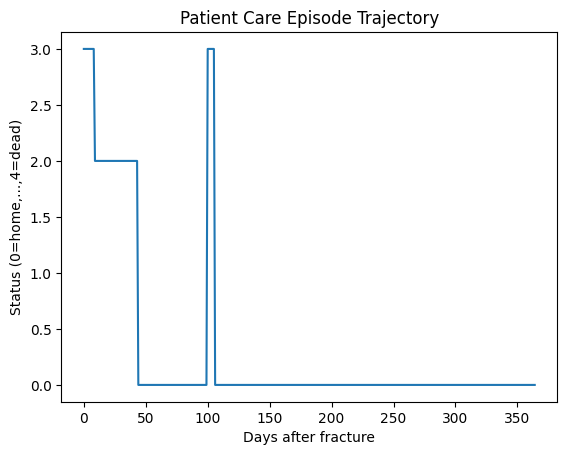

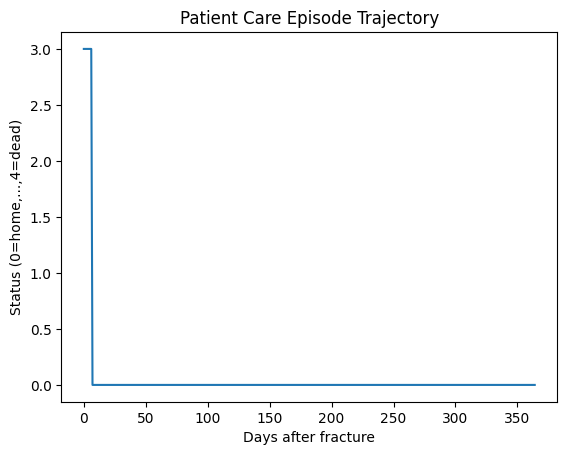

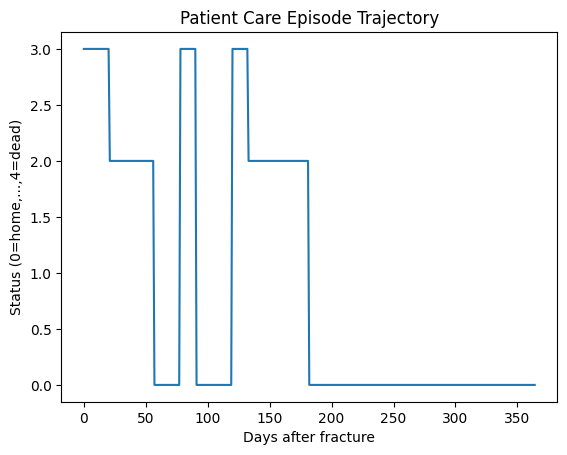

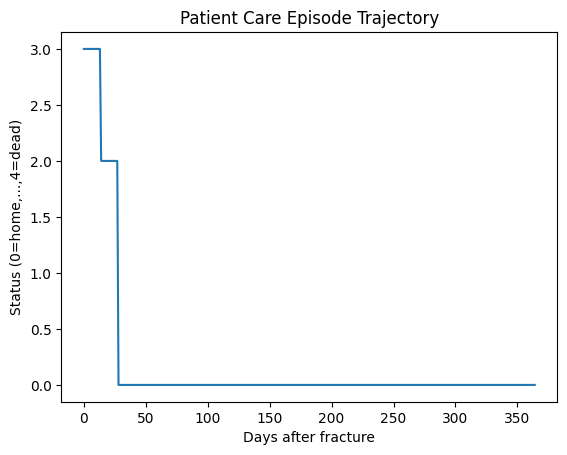

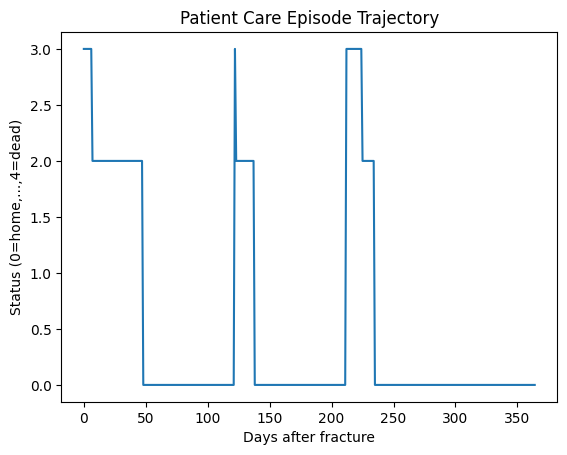

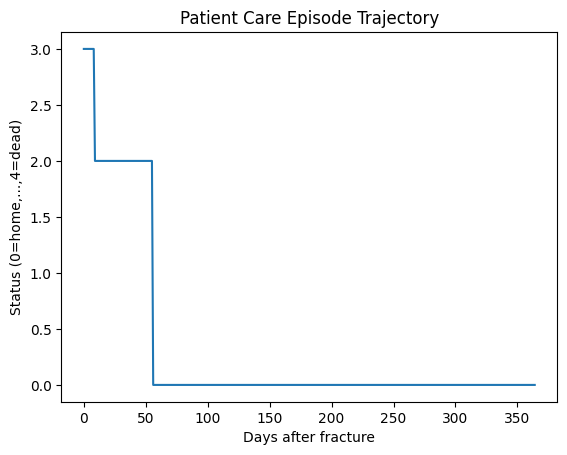

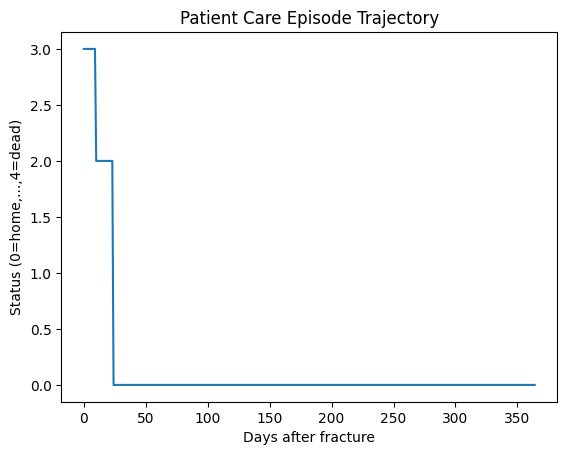

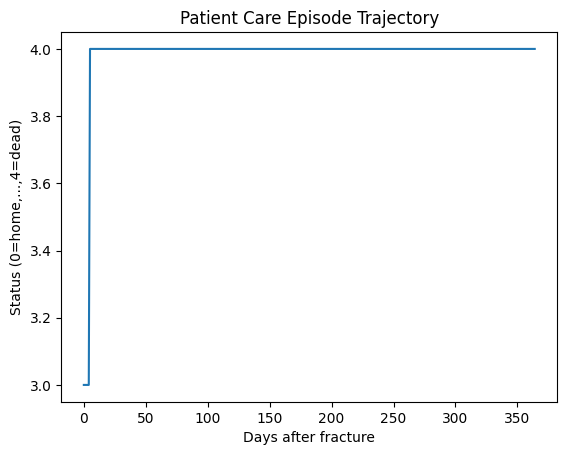

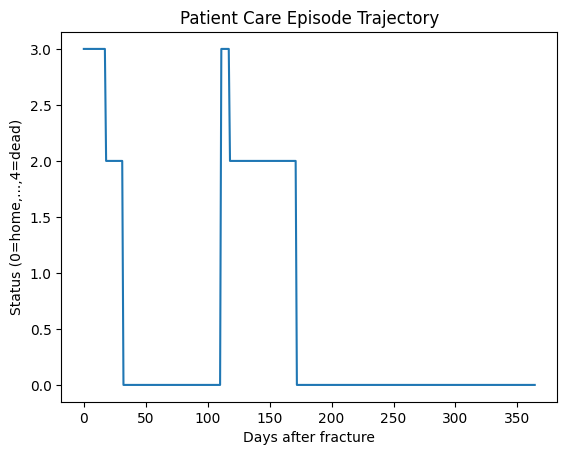

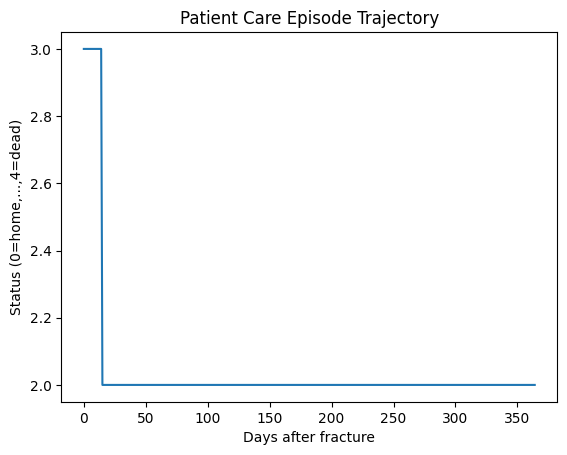

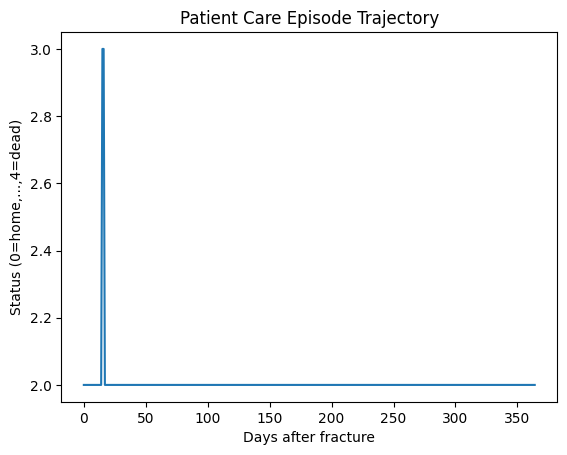

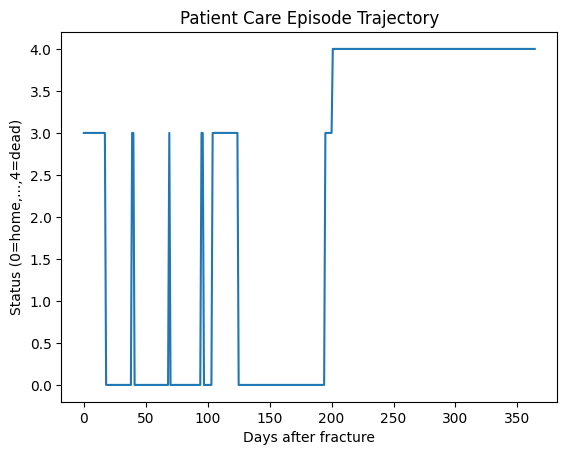

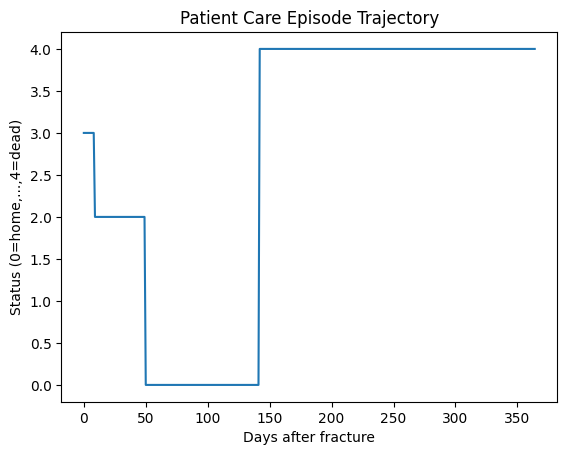

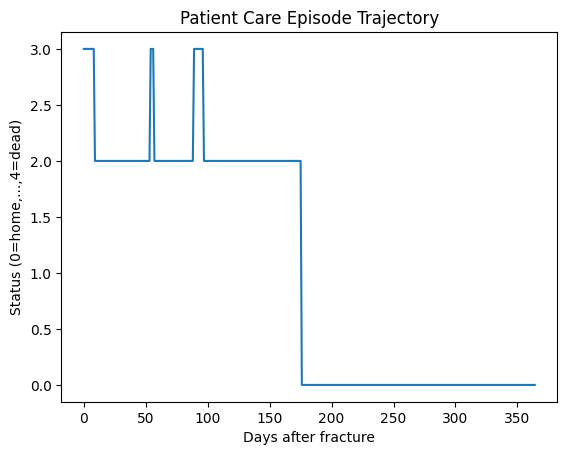

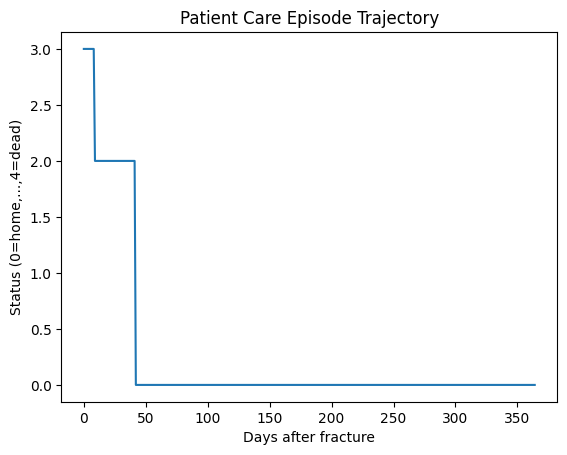

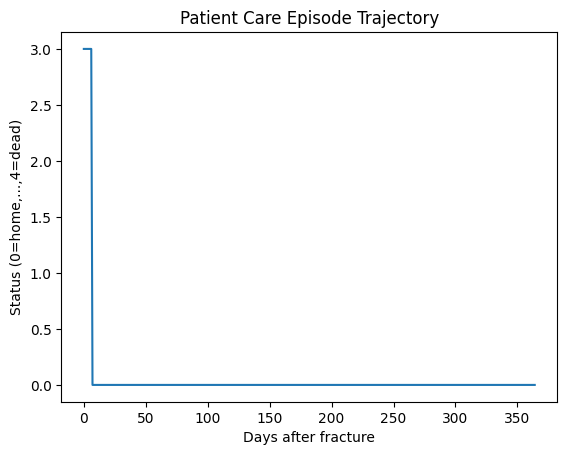

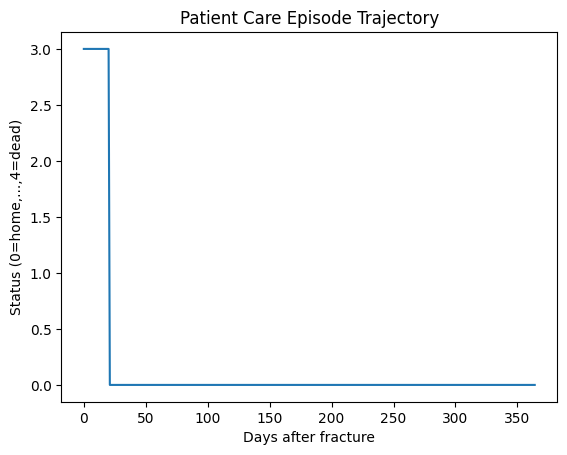

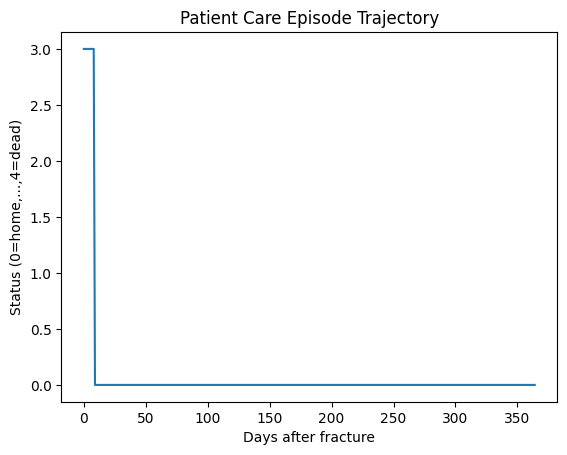

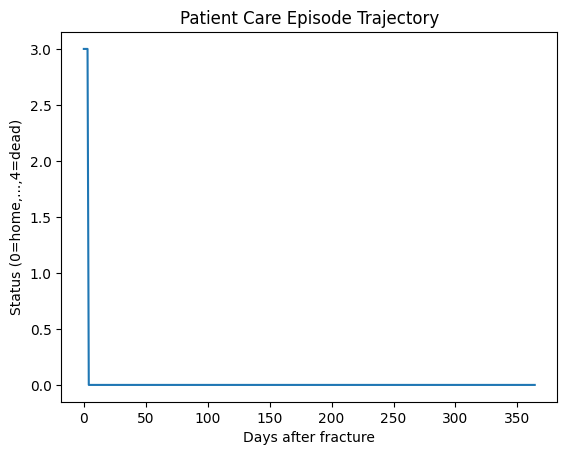

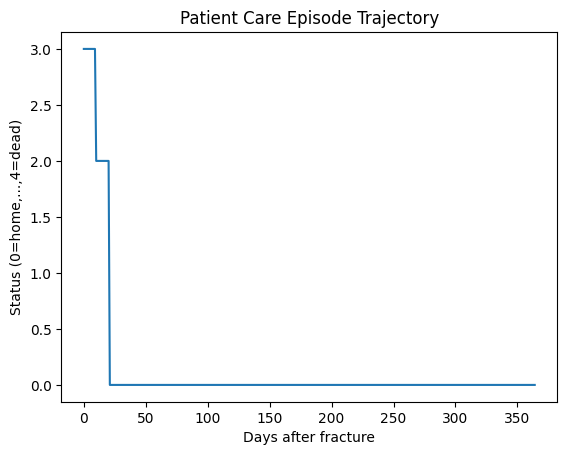

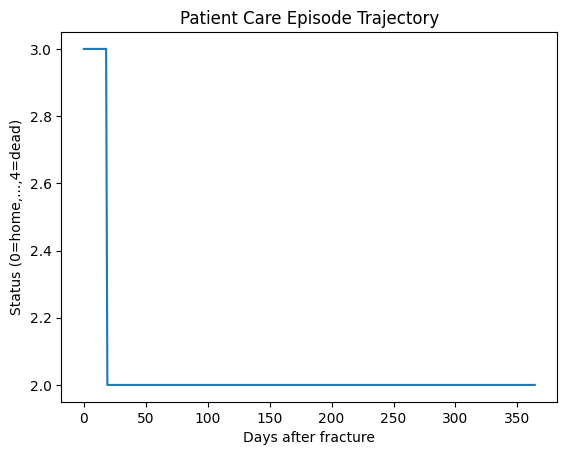

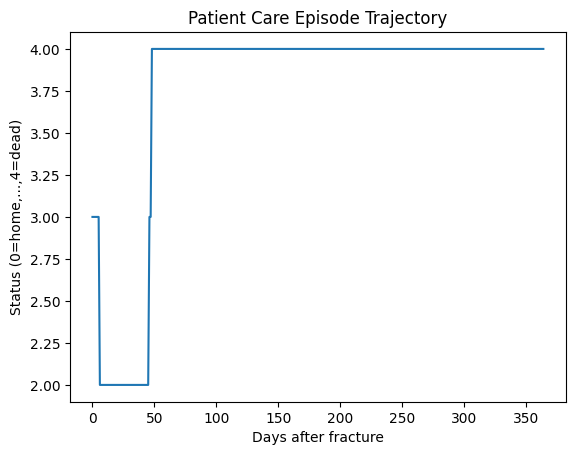

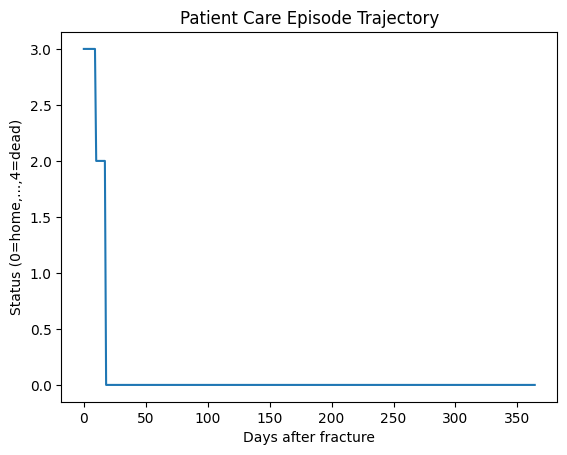

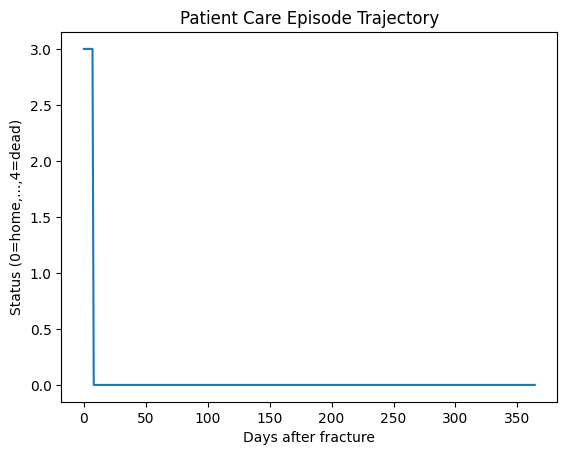

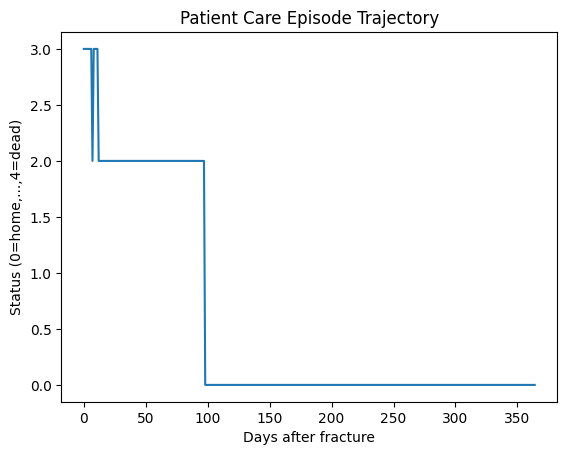

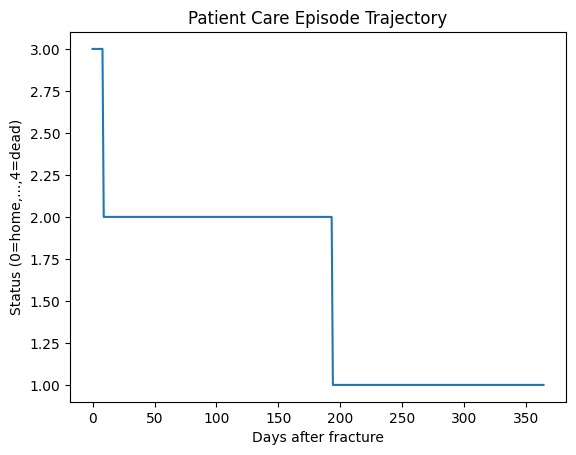

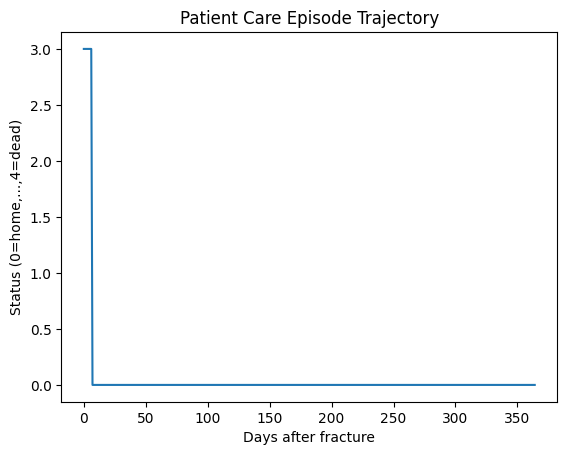

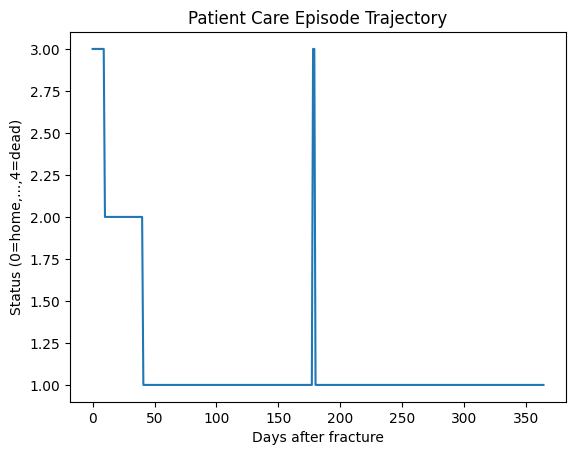

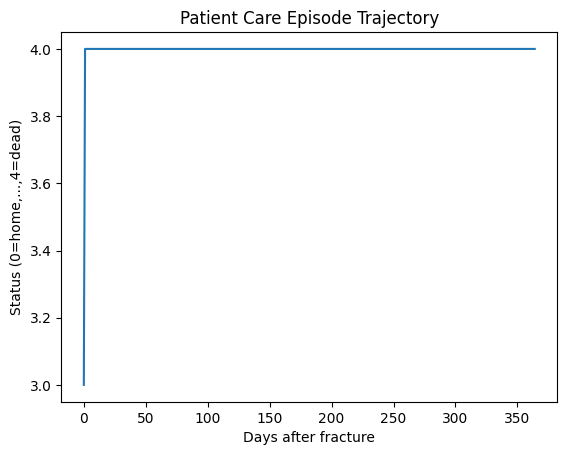

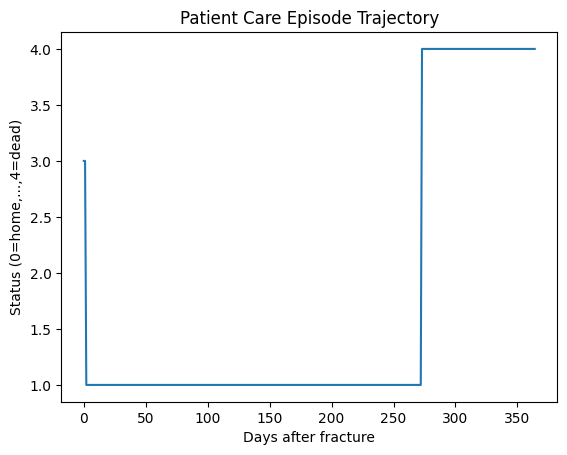

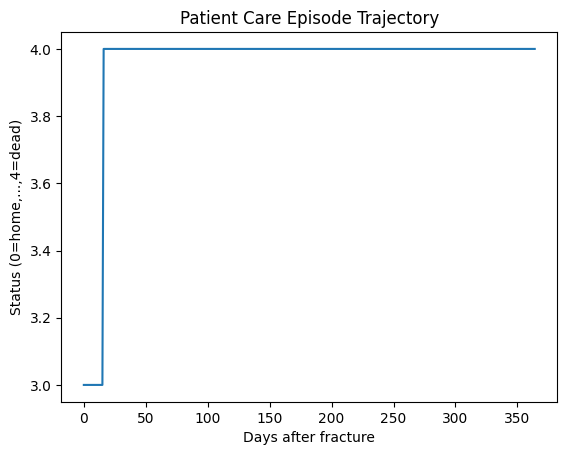

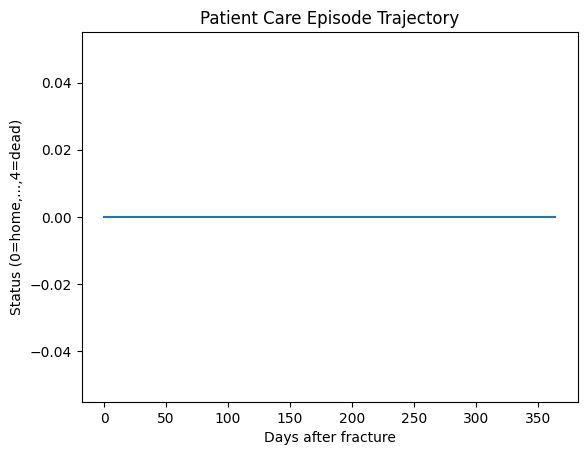

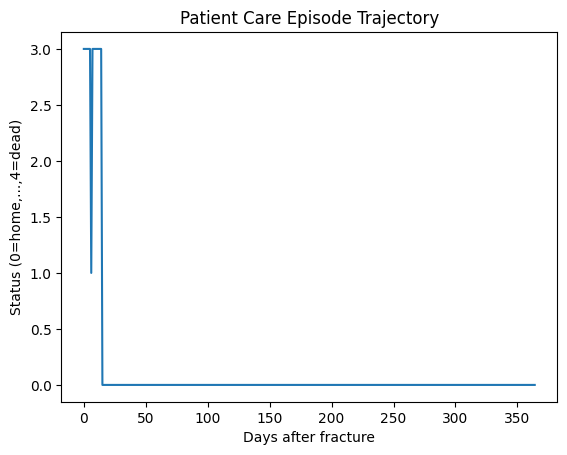

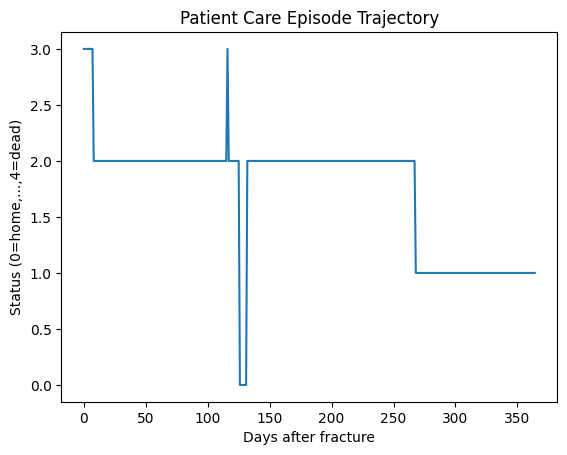

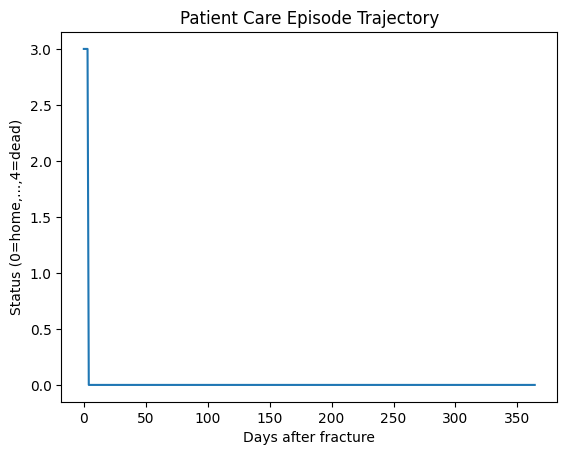

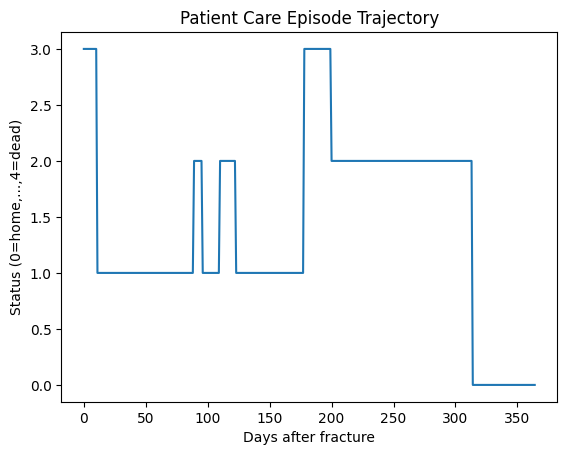

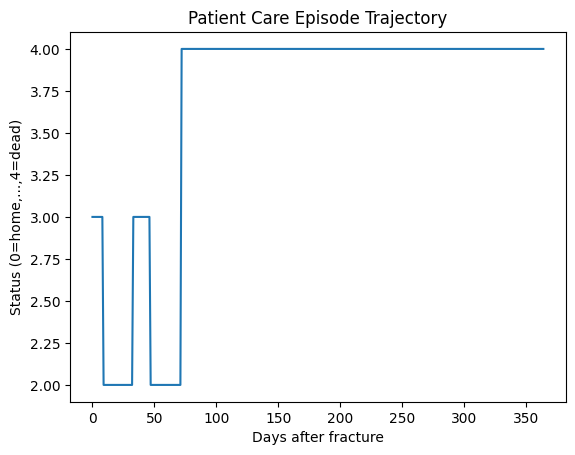

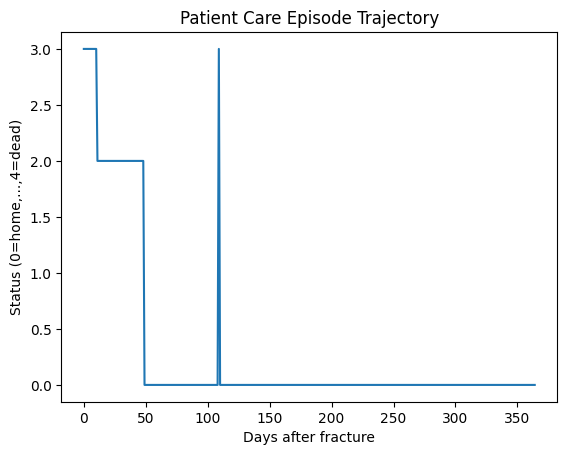

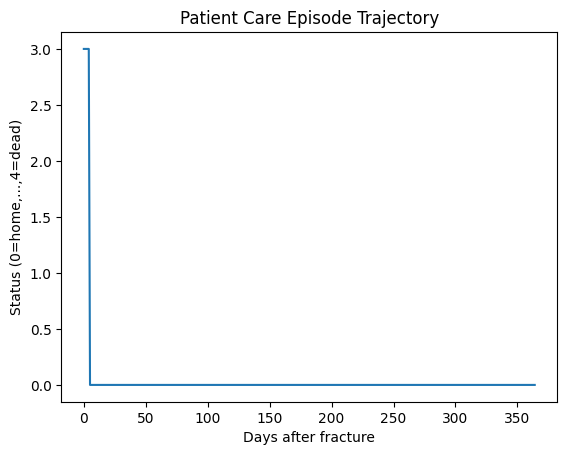

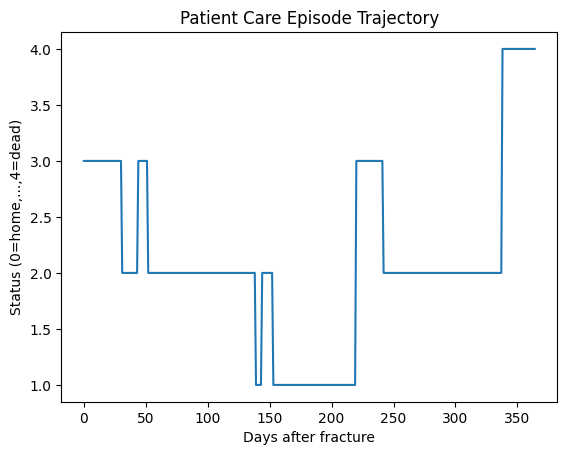

In [25]:
for i in range(0,40): #(0,515)
  patient = df.iloc[i,1:]
  plt.plot(patient.values)
  plt.title("Patient Care Episode Trajectory")
  plt.xlabel("Days after fracture")
  plt.ylabel("Status (0=home,...,4=dead)")
  plt.show()

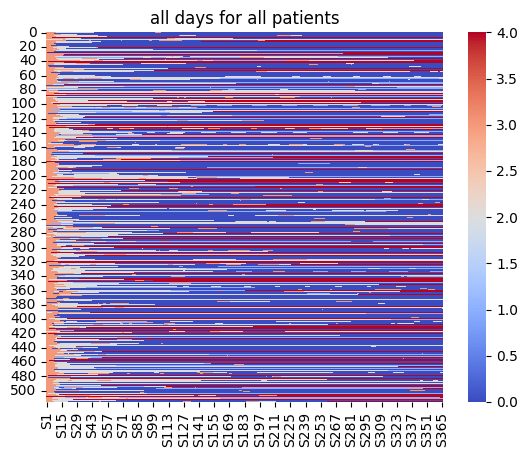

In [26]:
sns.heatmap(df.iloc[:,1:515], cmap="coolwarm", cbar=True)
plt.title("all days for all patients")
plt.show()

#Clustering

stable situation, only gets better, only gets worse, unstable situation

In [27]:
def classify_patient(row):
    values = row.values
    start, end = values[0], values[-1]
    diffs = np.diff(values)

    num_changes = np.sum(diffs != 0)
    ever_worse = np.any(diffs > 0)   # goes worse
    ever_better = np.any(diffs < 0)  # gets better

    # --- rules ---
    if num_changes == 0:
        return "Stable situation"
    elif (not ever_worse) and (end <= start):
        return "Only gets better"
    elif (not ever_better) and (end >= start):
        return "Only gets worse"
    else:
        return "Unstable situation"

# classification
df["cluster"] = df.drop("ID", axis=1).apply(classify_patient, axis=1)

# outcome
print(df["cluster"].value_counts())
df.head()

cluster
Unstable situation    278
Only gets better      199
Only gets worse        29
Stable situation       10
Name: count, dtype: int64


,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S357,S358,S359,S360,S361,S362,S363,S364,S365,cluster
0,1,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Unstable situation
1,2,3,3,3,3,3,3,3,0,0,...,0,0,0,0,0,0,0,0,0,Only gets better
2,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Unstable situation
3,4,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,Only gets better
4,5,3,3,3,3,3,3,3,2,2,...,0,0,0,0,0,0,0,0,0,Unstable situation


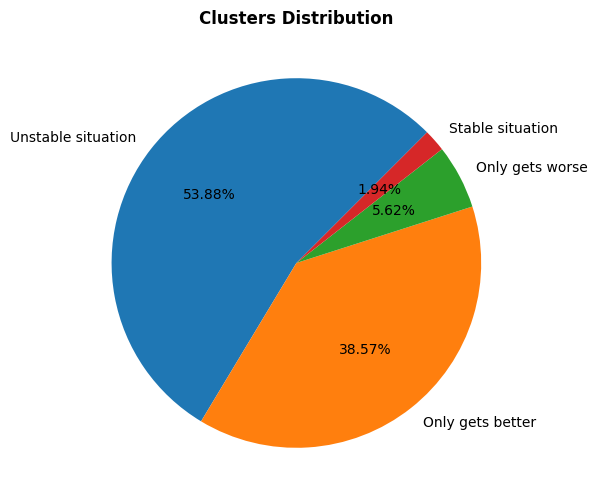

In [28]:
#Pie chart
plt.figure(figsize=(6,6))
plt.pie(
    df["cluster"].value_counts(),
    labels=df["cluster"].value_counts().index,
    autopct='%1.2f%%',
    startangle=45
)
plt.title("Clusters Distribution", fontweight='bold')
plt.show()

# Analyzing patients with a stable situation:

In [29]:
stable_situation = df[df["cluster"]=="Stable situation"]
stable_situation.head()

,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S357,S358,S359,S360,S361,S362,S363,S364,S365,cluster
31,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Stable situation
74,75,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Stable situation
88,89,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,Stable situation
130,131,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,Stable situation
140,141,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,Stable situation


They pass away or are alive and have returned home after surgery.

S1
Pass away    6
Alive        4
Name: count, dtype: int64


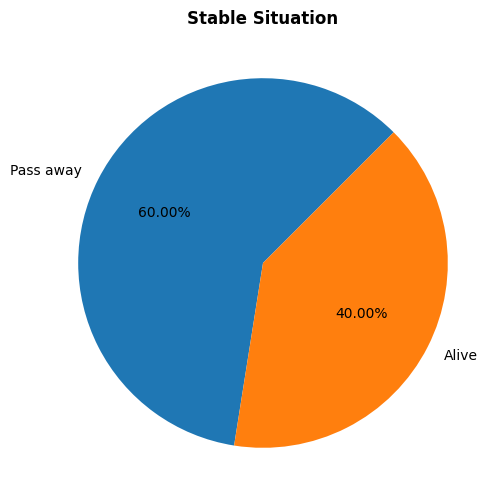

In [30]:
labels_map = {0: "Alive", 4: "Pass away"}
print(stable_situation["S1"].replace(labels_map).value_counts())

#Pie chart
plt.figure(figsize=(6,6))

plt.pie(
    stable_situation["S1"].value_counts(),
    labels=["Alive" if x == 0 else "Pass away" for x in stable_situation["S1"].value_counts().index],
    autopct='%1.2f%%',
    startangle=45
)
plt.title("Stable Situation", fontweight='bold')
plt.show()

# Analyzing patients who only gets worse:

In [40]:
OGW = df[df["cluster"]=="Only gets worse"]
OGW

,ID,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S357,S358,S359,S360,S361,S362,S363,S364,S365,cluster
7,8,3,3,3,3,3,4,4,4,4,...,4,4,4,4,4,4,4,4,4,Only gets worse
28,29,3,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,Only gets worse
30,31,3,3,3,3,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,Only gets worse
40,41,3,3,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,Only gets worse
42,43,3,3,3,3,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,Only gets worse
85,86,3,3,3,3,3,3,3,4,4,...,4,4,4,4,4,4,4,4,4,Only gets worse
99,100,3,3,3,3,3,3,4,4,4,...,4,4,4,4,4,4,4,4,4,Only gets worse
132,133,3,3,3,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,Only gets worse
157,158,3,3,3,3,3,3,3,3,3,...,4,4,4,4,4,4,4,4,4,Only gets worse
205,206,3,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,Only gets worse


How many times jump and when

In [45]:
# Function to get jumps info
def get_jumps(row):
    values = row.values
    diffs = np.diff(values)

    jump_days = np.where(diffs > 0)[0] + 2  # +2 : diff shifts (1) and day starts at S1
    num_jumps = len(jump_days)

    return pd.Series([num_jumps, jump_days], index=["num_jumps", "jump_days"])

# delet ID and cluster
jump_info = OGW.drop(["ID", "cluster"], axis=1).apply(get_jumps, axis=1)

# Show result
jump_info.head()

,num_jumps,jump_days
7,1,[6]
28,1,[2]
30,1,[17]
40,1,[3]
42,1,[17]


In [33]:
print(jump_info["num_jumps"].value_counts())

num_jumps
1    29
Name: count, dtype: int64


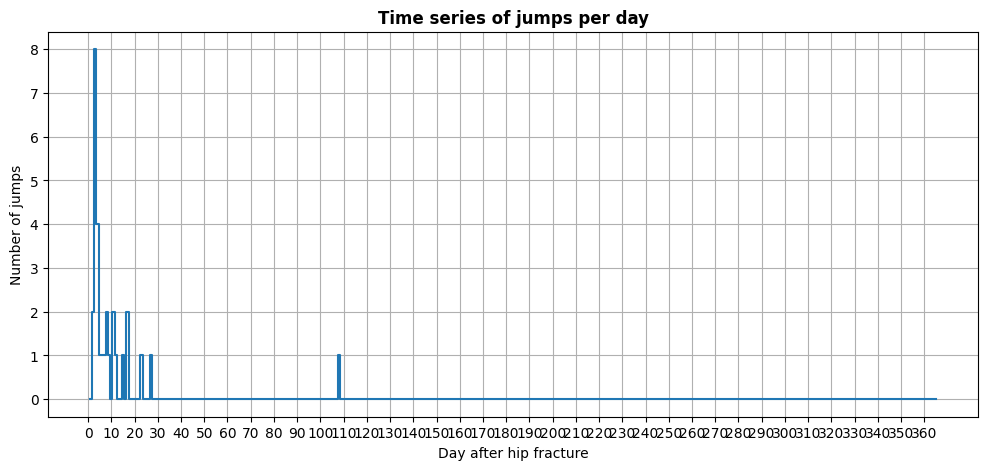

In [52]:
from collections import Counter

all_jump_days = [day for sublist in jump_info["jump_days"] for day in sublist]
day_counts = Counter(all_jump_days)

days = np.arange(1, 366)
jump_per_day = [day_counts.get(d, 0) for d in days]

plt.figure(figsize=(12,5))
plt.plot(days, jump_per_day, drawstyle='steps-mid')
plt.xlabel("Day after hip fracture")
plt.ylabel("Number of jumps")
plt.title("Time series of jumps per day", fontweight='bold')

max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 10)
plt.xticks(xticks)

plt.grid(True)
plt.show()


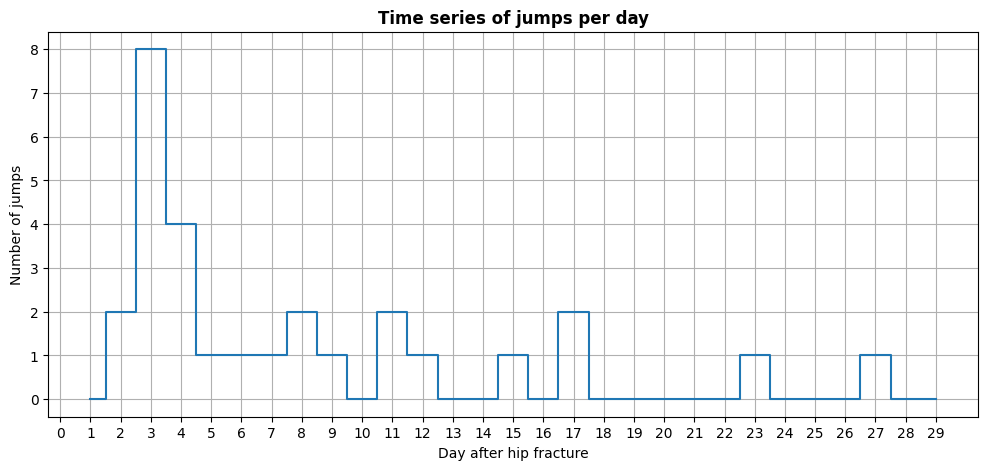

In [55]:
from collections import Counter

all_jump_days = [day for sublist in jump_info["jump_days"] for day in sublist]
day_counts = Counter(all_jump_days)

days = np.arange(1, 30)
jump_per_day = [day_counts.get(d, 0) for d in days]

plt.figure(figsize=(12,5))
plt.plot(days, jump_per_day, drawstyle='steps-mid')
plt.xlabel("Day after hip fracture")
plt.ylabel("Number of jumps")
plt.title("Time series of jumps per day", fontweight='bold')

max_x = int(np.max(days))
xticks = np.arange(0, max_x+1, 1)
plt.xticks(xticks)

plt.grid(True)
plt.show()
